**<h1>Download the raw data</h1>**

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   109M      0  0:00:07  0:00:07 --:--:--  114M


In [2]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip
 PetImages		  'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


In [4]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<h1>Remove the corrupted images</h1>**

In [6]:
import tensorflow as tf
from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

should_rewrite_image = True # set to true if you are getting Corrupt Data error
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join('PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            write_file(fpath, tmp)

print("Deleted %d images" % num_skipped)

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


Deleted 2 images


**<h1>Generate a dataset</h1>**

In [7]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


**<h1>Visualize the data</h1>**

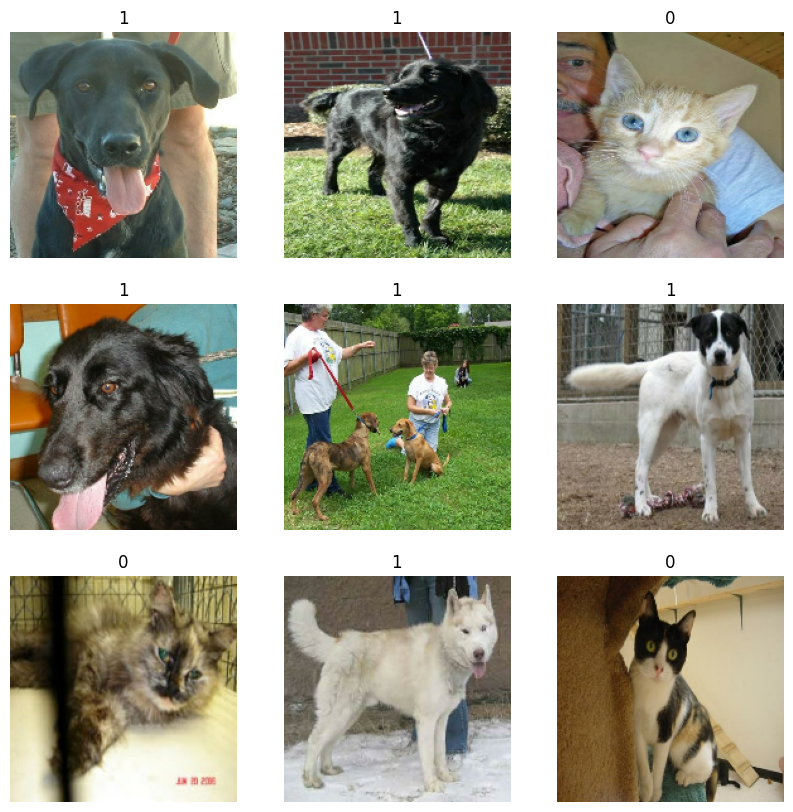

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**<h1>Using image data augmentation</h1>**

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

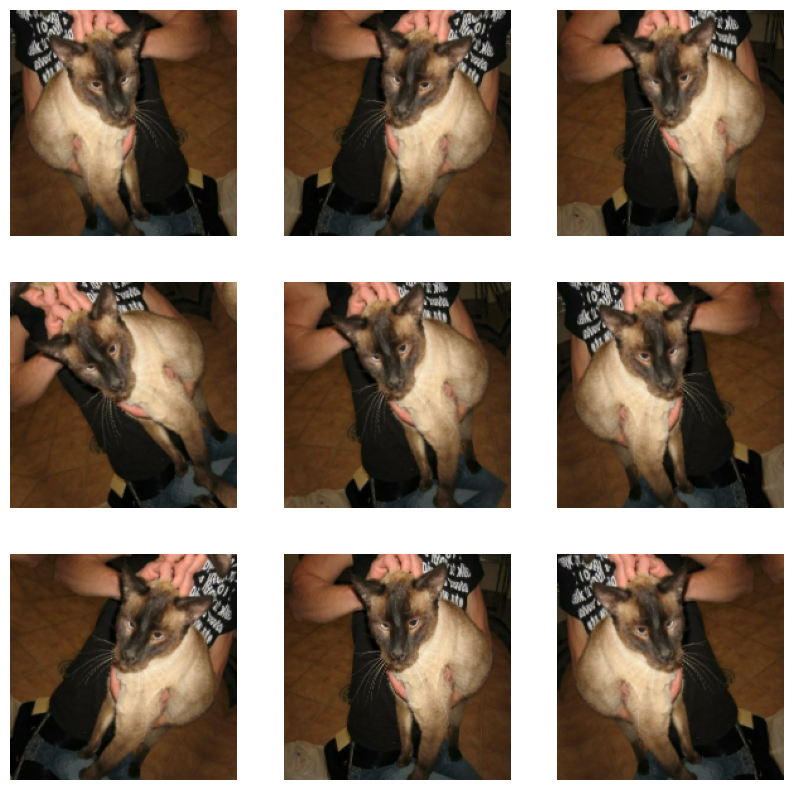

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [11]:
# Apply `data_augmentation` to the training images.
#train_ds = train_ds.map(
    #lambda img, label: (data_augmentation(img), label),
    #num_parallel_calls=tf_data.AUTOTUNE,
#)
# Prefetching samples in GPU memory helps maximize GPU utilization.
#train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
#val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

**<h1>Build the model</h1>**

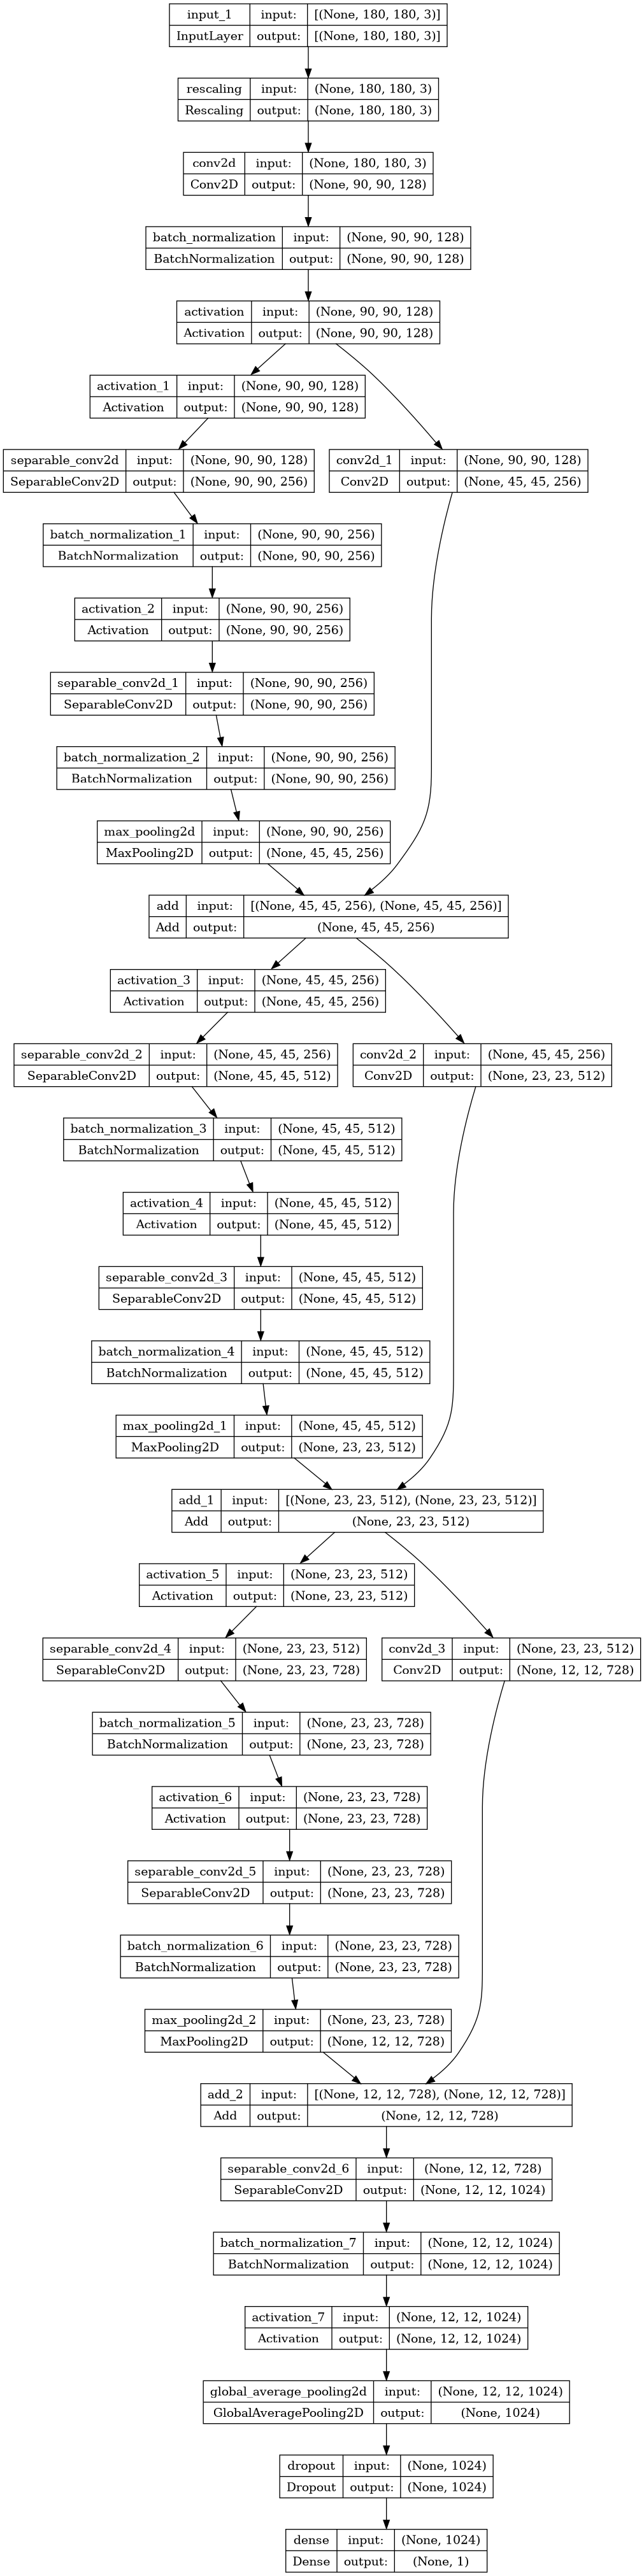

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**<h1>Train the model</h1>**

In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 246s 1s/step - loss: 0.5568 - acc: 0.6978 - val_loss: 0.6992 - val_acc: 0.4957
Epoch 2/25
147/147 [==============================] - 208s 1s/step - loss: 0.4155 - acc: 0.8007 - val_loss: 0.6933 - val_acc: 0.4957
Epoch 3/25
147/147 [==============================] - 209s 1s/step - loss: 0.3113 - acc: 0.8596 - val_loss: 0.6904 - val_acc: 0.4957
Epoch 4/25
147/147 [==============================] - 209s 1s/step - loss: 0.2345 - acc: 0.8979 - val_loss: 0.7135 - val_acc: 0.5032
Epoch 5/25
147/147 [==============================] - 209s 1s/step - loss: 0.1667 - acc: 0.9302 - val_loss: 1.4718 - val_acc: 0.4994
Epoch 6/25
147/147 [==============================] - 209s 1s/step - loss: 0.1099 - acc: 0.9545 - val_loss: 0.5102 - val_acc: 0.7839
Epoch 7/25
147/147 [==============================] - 209s 1s/step - loss: 0.0615 - acc: 0.9783 - val_loss: 0.3331 - val_acc: 0.8524
Epoch 8/25
147/147 [==============================] - 210s 1s/step - 

**<h1>Run inference on new data</h1>**

1/1 [==============================] - 0s 20ms/step
This image is 93.25% cat and 6.75% dog.


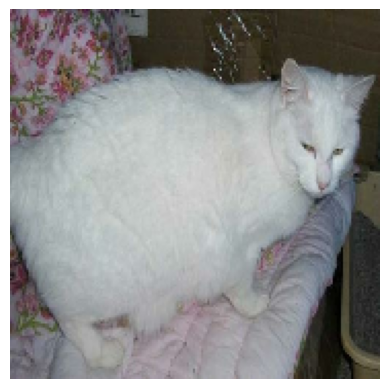

In [42]:
img = keras.utils.load_img("PetImages/Cat/6595.jpg", target_size=image_size)

# Assuming 'img' is your image loaded with some method (e.g., PIL or cv2)
plt.imshow(img)
plt.axis("off")

# Convert the image to a NumPy array
img_array = keras.preprocessing.image.img_to_array(img)

# Add a batch axis using tf.expand_dims
img_array = tf.expand_dims(img_array, 0)

# Assuming 'model' is your trained model
predictions = model.predict(img_array)
score = float(tf.sigmoid(predictions[0][0]))

print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")